# Starbucks Capstone Challenge

This analysis focuses on Starbuck's offer data and rating. The analysis also goes hand in hand with the thesis on achieving the Data Scientist Nanodegree Project. The data extract was provided by Udacity [Data Scientist Nanodegree](https://www.udacity.com/course/data-scientist-nanodegree--nd025) (https://www.udacity.com/).


## Table of Contents
<ol>
    <li><a href="#intro">Introduction</a></li>
    <li><a href="#business">Business Understanding - Problem Statement</a></li>
    <li><a href="#Gather">Gather</a></li>
    <li><a href="#GetData">Get the data</a>
    <li><a href="#DataUnder">Data Understanding</a>
    <ol type="1">
        <li><a href="#transcript">Transcripts</a></li>
        <li><a href="#profile">Profile</a></li>
        <li><a href="#portfolio">Portfolio</a></li>
    </ol></li>
    <li><a href="#DataPrep">Data Preparation</a>
    <ol type="1">
        <li><a href="#cleanportfolio">Cleaning Data Frame Portfolio</a>
        <li><a href="#cleanprofile">Cleaning Data Frame Profile</a>
        <li><a href="#cleantranscript">Cleaning Data Frame Transcripts</a>
        <li><a href="#engineer">Feature Engineering</a>
    </ol></li> 
    <li><a href="#Model">Modeling</a>
    <ol type="1">
        <li><a href="#LabelModel">Label for Modeling</a></li>
        <li><a href="#NormModel">Normalize for Modeling </a></li>
        <li><a href="#pipline">Make a Pipline to Find the Best Model</a></li> 
        <li><a href="#improvements">Model Improvements</a></li> 
    </ol></li>
    <li><a href="#evaluation">Evaluation, design and show the results</a>
    <ol type="1">
        <li><a href="#features">Find the Best Features</a></li>
        <li><a href="#PCA">PCA with the Offer Model</a></li>
        <li><a href="#EvalConclusion">Conclusion</a></li>
        <li><a href="#Enhancement">Possible Enhancement in the Future</a></li>
    </ol></li>
    <li><a href="#Deploy">Deployment</a>
</ol>

<a id='intro'></a>
## 1. Introduction

The data and methods used in this notebook are used by implementing the cross-industry standard process for data mining (CRISP-DM) as part of the project requirements for Udacity's data scientist Nanodegree. The CRISP-DM process encompasses six elements:

1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation
6. Deployment

The data is gathered, explored and models built on it. When the results are completed, they are made available in the form of a blog post that is aimed at a general target group and informs them about the action elements.

<a id='business'></a>
## 2. Problem Statement - Business Understanding

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks.

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

The given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer.

In some case might make a purchase through the app without having received an offer or seen an offer.

1. Who are Starbucks customers (gender and age)
2. What income do customers have and what do they spend
3. How can offers be assigned to customers (offer, age group, gender)
4. Which offers are most accepted by customers (type of offer, customer group (m / f / c / d))


<a id='Gather'></a>
## 3. Gather 

First, let's read the  necessary libraries and set initial value.

In [1]:
# Import python libraries and data
import pandas as pd
import numpy as np
import math
import json
import re
import matplotlib.pyplot as plt
import datetime
import time
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer, fbeta_score

In [2]:
!python --version

Python 3.7.3


<a id='GetData'></a>
## 4. Get the data

The program used to create the data simulates how people make purchasing decisions and how those decisions are influenced by promotional offers.
Each person in the simulation has some hidden traits that influence their purchasing patterns and are associated with their observable traits. People produce various events, including receiving offers, opening offers, and making purchases.
As a simplification, there are no explicit products to track. Only the amounts of each transaction or offer are recorded.
There are three types of offers that can be sent: buy-one-get-one (BOGO), discount, and informational. In a BOGO offer, a user needs to spend a certain amount to get a reward equal to that threshold amount. In a discount, a user gains a reward equal to a fraction of the amount spent. In an informational offer, there is no reward, but neither is there a requisite amount that the user is expected to spend. Offers can be delivered via multiple channels.
The basic task is to use the data to identify which groups of people are most responsive to each type of offer, and how best to present each type of offer.

At first I look which data are avialable. The data is contained in three files:

- **portfolio.json** - containing offer ids and meta data about each offer (duration, type, etc.)
- **profile.json** - demographic data for each customer
- **transcript.json** - records for transactions, offers received, offers viewed, and offers completed


In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

<a id='DataUnder'></a>
## 5. Data Understanding

In order to get a better understanding of the data I'll looking closer, let's take a look at some of the characteristics of the dataset. Here is the schema and explanation of each variable in the files:


**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [4]:
def summary(data):
    """ 
    Give a summary of the dataset
   
    Input:
    data (DF): DataFrame

    Returns:
    Print statement with data shape and percentage
    """
    data.info(verbose=True)
    print('\n')
    print((data.isnull().sum()[data.isnull().sum()>0]/data.shape[0])*100)
    print('\n')  
    print("no missing values")
    print(set(data.columns[data.isnull().mean()==0])) #Provide a set of columns with 0 missing values.
    print('\n')
    print("most missing values")
    print(set(data.columns[data.isnull().mean() > 0.75])) #Provide a set of columns with more than 75% of the values missing  

<a id='portfolio'></a>
### 5.1. Portfolio

In [5]:
summary(portfolio)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
reward        10 non-null int64
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
offer_type    10 non-null object
id            10 non-null object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


Series([], dtype: float64)


no missing values
{'duration', 'offer_type', 'reward', 'channels', 'id', 'difficulty'}


most missing values
set()


In [6]:
# give me some samples
portfolio.sample(5)

,reward,channels,difficulty,duration,offer_type,id
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd


In [7]:
# give me a deeper look in the channels 
portfolio.channels.sample(5)

0         [email, mobile, social]
4                    [web, email]
8    [web, email, mobile, social]
2            [web, email, mobile]
9            [web, email, mobile]
Name: channels, dtype: object

**Interim result**

The first look at the portfolio data frame gives a hint with no missing values by only 10 entries. That's a smale data set. But it appears that some duplicates are included. The `channel` also contains several pieces of information. These have to be divided. So I need a

- Cleaning function for row `channels` a bit flag for any type
- clean `duration` to hours expression instead days
- Make sure ther are no duplicates

<a id='profile'></a>
### 5.2. Profile

In [8]:
summary(profile)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 17000 non-null int64
id                  17000 non-null object
became_member_on    17000 non-null int64
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


gender    12.794118
income    12.794118
dtype: float64


no missing values
{'id', 'became_member_on', 'age'}


most missing values
set()


In [9]:
# give me some samples
profile.sample(5)

,gender,age,id,became_member_on,income
14076,M,70,594bea74b95e4cc1b6a2f95550c62b6e,20180112,66000.0
16126,None,118,ffecb1f8543f4bf7bade023de366d6bf,20171027,NaN
9372,F,58,6b36a1deee924d688236c11416854db0,20151005,32000.0
5277,None,118,1b4bf9e26285487f9db6dd6ea0f233d6,20180520,NaN
12517,None,118,82438a367b064f298f4a81ed2ad5f8b0,20180619,NaN


In [10]:
# here I have some unclear columns. let see what is the matter ...
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [11]:
# where I have some null values 
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [12]:
# a closer look into column age and gender
print(f"Age of unique customers and nulls to gender: {profile.age[profile.gender.isnull()][0]}")

Age of unique customers and nulls to gender: 118


In [13]:
# investigate the column gender a little bit more
print(f"Count age vs gender with null values: {profile.age[profile.gender.isnull()].value_counts().iloc[0]}")
print(f"Count unqiue customers with null values: {profile.age[profile.gender.isnull()].nunique()}")

Count age vs gender with null values: 2175
Count unqiue customers with null values: 1


**Interim result**

17,000 customer data are available in the profile file. For some columns, such as `gender` and `income` variables, no information is available. These have to be resolved.

A customer seems to have an unusual record. This has an age of 118 years. Since this interferes with further evaluation, it is later deleted from the file with a cleaning function.

So it looks like the following tasks are pending: 

- Make sure there are no duplications
- `became_member_on` should be converted to date
    - should split into `year`, `month`, `day`
- Fill NULL values for `gender` and `income` values
    - `gender` is a categorical variable, so you can fill gender with "O" for other
    - `income` needs to be filled with value that is apropriate with income distributions
- Delete unusual row with `age` 118

<a id='transcript'></a>
### 5.3. Transcript

In [14]:
summary(transcript)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
person    306534 non-null object
event     306534 non-null object
value     306534 non-null object
time      306534 non-null int64
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


Series([], dtype: float64)


no missing values
{'value', 'person', 'event', 'time'}


most missing values
set()


In [15]:
# give me some samples
transcript.sample(5)

,person,event,value,time
196021,d51cb02965d34146949deb979c1d6ae9,transaction,{'amount': 0.97},480
166554,a5de55851a684b2f8b31a7d9043f0210,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},408
128825,8ed66913c59348ca9e5ff003863ff830,offer viewed,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},342
169254,8d87b4721b494123b655374a403a75ed,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},414
22404,5cc1bd3f5c374619af785107a9fe684f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},24


In [16]:
# what can I do with the time column
transcript.time.describe()

count    306534.000000
mean        366.382940
std         200.326314
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64

In [17]:
# the value column has several characteristics. let's take a closer look
transcript.value.sample(10)

4748       {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
71499                                     {'amount': 19.12}
236890                                     {'amount': 27.8}
174489    {'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...
270587                                    {'amount': 21.43}
120341     {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
111607     {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
152004     {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
302969    {'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...
229773                                     {'amount': 2.51}
Name: value, dtype: object

**Interim result**

The transcription file contains 306,534 entries. Here the variable `time` seems to be a key message. It specifies the dwell time for an event or every transaction for an offer. Here this column has to be considered in the cleaning function. Furthermore, the `value` column appears to contain more information. These have to be divided.

Some updates that need to be made:
- The `value` column needs has two different items and need to split in `value_type` and `value`

<a id='DataPrep'></a>
## 6 Data Preparation


<a id='cleanportfolio'></a>
### 6.1 Cleaning Data Frame Portfolio
 

In [18]:
# copy the results ...
portfolio_clean = portfolio.copy()

In [19]:
# lets splitting the channels in portfolio data frame and drop the source column

def col_split(df, column):
    splits = []
    for s in df[column]:
        for i in s:
            if i not in splits:
                splits.append(i)
    for split in splits:
        df[split] = df[column].apply(lambda x: 1 if split in x else 0)
        
    df.drop([column], axis=1, inplace=True) 
    
    return splits

col_split(portfolio_clean ,'channels')

['email', 'mobile', 'social', 'web']

In [20]:
# minutes are stored in the duration column. these should be converted into hours. thus
# a comparison with other data frames i.e. transcript is possible
portfolio_clean['duration'] = portfolio_clean['duration'] * 24

In [21]:
# rename id column in portfolio cause its a different to the other data frames 
portfolio_clean.rename(columns={'id': 'offer_id'}, inplace=True)

In [22]:
# Make sure that each row is unique
len(np.unique(portfolio_clean['offer_id'])) == len(portfolio_clean)

True

In [23]:
# One hot encode the 'offer_type' column
column_ordering = ['offer_id',
                    'difficulty',
                    'durationdays',
                    'reward',
                   'offer_type',
                   'offer_id',
                   'email',
                   'mobile',
                   'social',
                   'web'
                  ]
df_offertype = pd.get_dummies(portfolio['offer_type'])
column_ordering.extend(df_offertype.columns.values)
# Add the new offer type columns to data frame 
portfolio_clean = pd.concat([portfolio_clean, df_offertype], axis=1)

In [24]:
# show me the results
portfolio_clean.sample(5)

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web,bogo,discount,informational
7,0,0,72,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
6,2,10,240,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
1,10,10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
0,10,10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
5,3,7,168,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0


In [25]:
summary(portfolio_clean)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 12 columns):
reward           10 non-null int64
difficulty       10 non-null int64
duration         10 non-null int64
offer_type       10 non-null object
offer_id         10 non-null object
email            10 non-null int64
mobile           10 non-null int64
social           10 non-null int64
web              10 non-null int64
bogo             10 non-null uint8
discount         10 non-null uint8
informational    10 non-null uint8
dtypes: int64(7), object(2), uint8(3)
memory usage: 878.0+ bytes


Series([], dtype: float64)


no missing values
{'discount', 'offer_type', 'duration', 'reward', 'email', 'social', 'informational', 'web', 'bogo', 'mobile', 'offer_id', 'difficulty'}


most missing values
set()


In [26]:
# a deeper look into offer_type
portfolio_clean.groupby('offer_type')['offer_id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: offer_id, dtype: int64

**Interim result**

In the portfolio data there are a total of 4 offers for BOGO, 4 for discounts and 2 informative offers. The BOGO offers and discounts are the essential information.

<a id='cleanprofile'></a>
### 6.2 Cleaning Data Frame Profile
 

In [27]:
# lets clean data frame profile

def clean_df_profile(df):
    """
    Return cleaned datasets with all string variables for gender, age, income. Lastly convert 
    membership_start, membership_period, split became_member_on into year, month, day, date in
    dataframe with datetime. Also drop unusual customer.
    
    INPUTS:
        df - dataframe for profile
    OUTPUTS:
        df_clean - cleaned dataframe for profile
    """
    # copy for the results ...
    df_clean = df.copy()
    # For Gender, instead of assuming a gender, lets just make the gender Other
    df_clean['gender'].fillna('O', inplace = True)
    
    df_clean['age'] = df_clean['age'].apply(lambda x: int(x))
    # if there is no income, then take the average value
    df_clean['income'] = df_clean['income'].apply(lambda x: float(x))
    mean_val = profile.income.mean()
    df_clean['income'].fillna(mean_val, inplace = True)

    # adding a period of the membership by month
    df_clean['membership_start'] = df_clean.became_member_on.apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
    df_clean['membership_period'] = df_clean['membership_start'].dt.to_period('M')

    # converting the 'became_member_on' column to date respectively creating more.
    # So it means columns based on the year, month, day 
    df_clean['member_year'] = df_clean.became_member_on.apply(lambda x: int(str(x)[:4]))
    df_clean['member_month'] = df_clean.became_member_on.apply(lambda x: int(str(x)[4:6]))
    df_clean['member_day'] = df_clean.became_member_on.apply(lambda x: int(str(x)[6:]))
    df_clean['member_date'] = df_clean.became_member_on.apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
    df_clean.drop('became_member_on', axis = 1, inplace = True)
    
    # renaming the id column for the profile data
    df_clean.rename(columns={'id': 'customer_id'}, inplace=True)
    
    # drop the costumer whose age value is '118'
    df_clean = df_clean[df.age != 118]
    
    return df_clean

In [28]:
# bevor I clean the profile data it's necassary to save the unuasal customer
customer_to_drop = profile[profile['age'] == 118]

In [29]:
# clean the dataframes profile
profile_clean = clean_df_profile(profile)

In [30]:
# show me the results
profile_clean.sample(5)

,gender,age,customer_id,income,membership_start,membership_period,member_year,member_month,member_day,member_date
4233,F,25,93e6fefaf5ba4d1594d57f3120603819,45000.0,2017-06-06,2017-06,2017,6,6,2017-06-06
4765,M,36,549dcda4abdb4803aa423e1d982a5f30,66000.0,2018-05-07,2018-05,2018,5,7,2018-05-07
5497,F,60,0cc00e05b6be41e78d8385f64ccb5e15,118000.0,2016-09-13,2016-09,2016,9,13,2016-09-13
7433,F,46,8f1d8f4875d04c83b826a9df90dedfe4,73000.0,2018-04-11,2018-04,2018,4,11,2018-04-11
1683,M,50,91a2e177e57a4a2287e02a4fc8efa6bb,62000.0,2018-06-27,2018-06,2018,6,27,2018-06-27


In [31]:
summary(profile_clean)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 10 columns):
gender               14825 non-null object
age                  14825 non-null int64
customer_id          14825 non-null object
income               14825 non-null float64
membership_start     14825 non-null datetime64[ns]
membership_period    14825 non-null period[M]
member_year          14825 non-null int64
member_month         14825 non-null int64
member_day           14825 non-null int64
member_date          14825 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(4), object(2), period[M](1)
memory usage: 1.2+ MB


Series([], dtype: float64)


no missing values
{'member_year', 'gender', 'member_date', 'age', 'customer_id', 'membership_period', 'member_day', 'income', 'member_month', 'membership_start'}


most missing values
set()


In [32]:
# check the cleaned profile data
profile_clean.age.describe()

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

In [33]:
profile_clean.income.describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

In [34]:
profile_clean.gender.describe()

count     14825
unique        3
top           M
freq       8484
Name: gender, dtype: object

In [35]:
# calculate the proportions of genders and give me the percentage
gender_perc = profile_clean['gender'].value_counts()
gender_perc *= 100 / gender_perc.sum()
gender_perc

M    57.227656
F    41.342327
O     1.430017
Name: gender, dtype: float64

In [36]:
# Let's look at what year a customer became a member of rewards
# count per year
profile_clean.member_year.value_counts()

2017    5599
2018    3669
2016    3024
2015    1597
2014     662
2013     274
Name: member_year, dtype: int64

In [37]:
# Let's look at what year a customer became a member of rewards
# percentages per year
start_year = profile_clean.member_year.value_counts()
start_year *= 100 / start_year.sum()
start_year

2017    37.767285
2018    24.748735
2016    20.397976
2015    10.772344
2014     4.465430
2013     1.848229
Name: member_year, dtype: float64

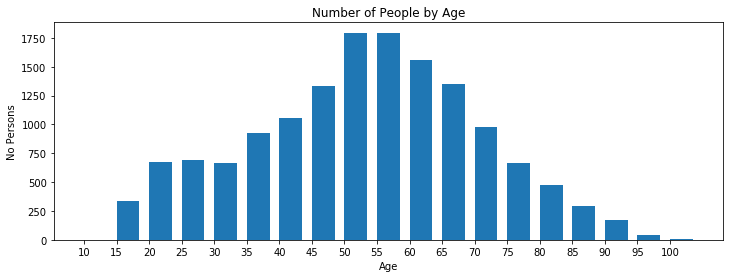

In [38]:
# Now I would like to visualize the results in relation to the age
profile_agegroup=profile_clean.groupby(pd.cut(profile_clean['age'], 
                                         np.arange(10, 105+5, 5)))['customer_id'].count()
plt.figure(figsize=(12,4))
plt.bar(np.arange(10, 105, 5),profile_agegroup,width=3.5, align='edge')
plt.xticks(np.arange(10, 105, 5))
plt.xlabel('Age')
plt.ylabel('No Persons')
plt.title('Number of People by Age')
plt.savefig("./figure/number_of_people_by_age.jpg")
plt.show()

In [39]:
# For income I need a group via age 
profile_age = profile_clean.copy()
interval_range = pd.interval_range(start=0, freq=10, end=120)
profile_age['agegroup'] = pd.cut(profile_age['age'], bins=interval_range, labels=[1,2,3])

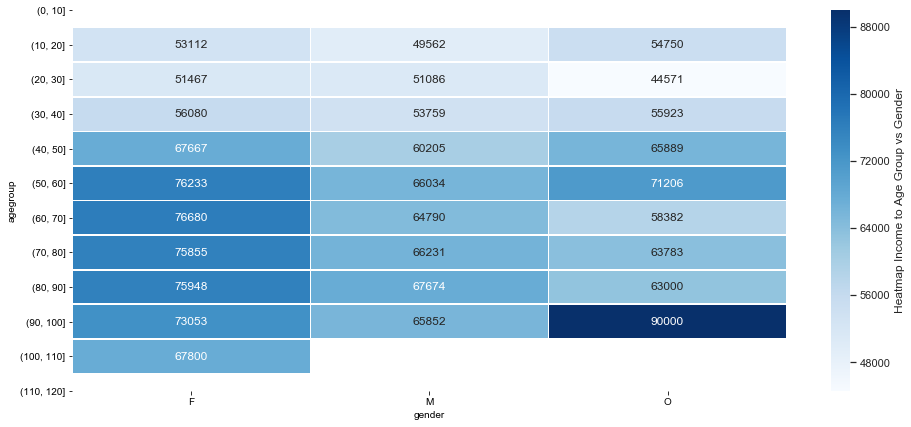

In [40]:
# heatmap of income vs age group
fig, ax = plt.subplots(figsize=(16,7));
# fig, ax = plt.subplots(2, gridspec_kw=grid_kws);
sns.set(font_scale=1.0)
profile_heat = sns.heatmap(profile_age.groupby(['agegroup', 'gender']).income.mean().unstack(),
                           cmap="Blues", annot=True, fmt=".0f", ax=ax, linewidth = 0.7,
                           cbar_kws={'label': 'Heatmap Income to Age Group vs Gender'});
profile_heat.set_yticklabels(profile_heat.get_yticklabels(), rotation=0)
fig = profile_heat.get_figure()
fig.savefig("./figure/heatmap_income_vs_agegroup.jpg", bbox_inches='tight')

**Interim Results**

There are 14825 profile data. I now know about customers that they have an average age of 54 years. The average income is 65,000.
With 8484, male customers were most involved in the rating. However, it was surprising that women between 50 and 90 years of age had a significantly higher income than their male competitors. In the available data, there is also an income swing for 90 to 100 year olds. However, this seems rather unusual.
In terms of timing, the business declined in 2018 with 3,669 entries, i.e. 24.75%. Most data was available in 2017 with 5599 entries, or 37.77%.

<a id='cleantranscript'></a>
### 6.3 Cleaning Data Frame Transcript
 

In [41]:
# lets clean data frame transcript

def clean_df_transcript(df):
    """
    Return cleaned datasets with all string variables for value, time and renamed customer_id.
    
    INPUTS:
        df - dataframe for transcript
    OUTPUTS:
        df_clean - cleaned dataframe for transcript
    """
    # copy for the results ...
    df_clean = df.copy()

    # splitting the value column
    # First value is the value_type
    df_clean['record'] = df_clean.value.apply(lambda x: list(x.keys())[0])
    df_clean['record_value'] = df_clean.value.apply(lambda x: list(x.values())[0])
        
    df_clean.drop(['value'], axis=1, inplace=True) 
    
    # Make sure that the time value is an integer amount
    df_clean['time'] = df_clean['time'].apply(lambda x: int(x))
    
    # Convert from hours to days
    df_clean['time'] /= 24.0
        
    # renaming the person and time columns for the transcript data
    df_clean.rename(columns={'person': 'customer_id'}, inplace=True)
    
    return df_clean

In [42]:
# clean the dataframes transcripts
transcript_clean = clean_df_transcript(transcript)

In [43]:
# the cleaning process is not finished ... the unusual customer must also droped in transcript
transcript_clean = transcript_clean[~transcript_clean.customer_id.isin(customer_to_drop.id)]

In [44]:
# show me the results
transcript_clean.sample(5)

,customer_id,event,time,record,record_value
250884,a6d2bc2a28094a07a5c273dc542cefdc,offer received,24.00,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7
151171,355ab404fc63416cbb0692b7ab9d51b6,offer received,17.00,offer id,fafdcd668e3743c1bb461111dcafc2a4
172124,be85e0f528c24ae9acae162d6a2bc832,offer viewed,17.50,offer id,ae264e3637204a6fb9bb56bc8210ddfd
279822,292fc9b98199494cb55c027f5bfac8aa,offer viewed,25.75,offer id,2906b810c7d4411798c6938adc9daaa5
285336,47abadbd4d4c42e2b38f71808f9c6cf3,transaction,26.25,amount,15.63


In [45]:
summary(transcript_clean)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 306532
Data columns (total 5 columns):
customer_id     272762 non-null object
event           272762 non-null object
time            272762 non-null float64
record          272762 non-null object
record_value    272762 non-null object
dtypes: float64(1), object(4)
memory usage: 12.5+ MB


Series([], dtype: float64)


no missing values
{'record_value', 'time', 'record', 'customer_id', 'event'}


most missing values
set()


In [46]:
# Give me the number of transcripts by event
transcript_clean.event.value_counts()

transaction        123957
offer received      66501
offer viewed        49860
offer completed     32444
Name: event, dtype: int64

In [47]:
# now show the percentage by event
transcript_clean['event'].value_counts(normalize = True)

transaction        0.454451
offer received     0.243806
offer viewed       0.182797
offer completed    0.118946
Name: event, dtype: float64

**Interims result**

In the transcript data, the customers carried out a total of 123,957 transactions. Only 32,444 actually accepted an offer here.

<a id='engineer'></a>
### 6.4 Feature Engineering


#### Get the Offer and Transaction to the Transcripts

Divide the transcript data into offers and transactions. Take into account the amount, time and offer types.

In [48]:
# Explaine now what is the most common promotion
def get_offer(df):
    """
    get the data frame offer and add to data frame transcript
    
    INPUTS:
        df - dataframe for transcript
    OUTPUTS:
        df_merge - merged dataframe offer to transcript
    """
    # copy for the results ...
    df_clean = transcript_clean.copy()
    
    # Remove customer id's that are not in the customer profile DataFrame
    select_data = df_clean['customer_id'].isin(profile_clean['customer_id'])
    df_clean = df_clean[select_data]

    # prepare data 
    df_clean.drop_duplicates(inplace=True)
    
    # Select customer offers and split it
    pattern_obj = re.compile('^offer (?:received|viewed|completed)')
    tmp_offer = lambda elem: pattern_obj.match(elem) != None
    is_offer = df_clean['event'].apply(tmp_offer)

    # give the results in a new data frame
    offer_data = df_clean[is_offer].copy()
    offer_data = offer_data.reset_index(drop=True)
    
    # renaming the id column for the profile data
    offer_data.rename(columns={'record_value': 'offer_id'}, inplace=True)
    
    # Initialize a list that describes the desired output DataFrame
    # column ordering
    column_order = ['customer_id', 'offer_id', 'time']

    # Transform a column that describes a customer offer event
    pattern_obj = re.compile('^offer ([a-z]+$)')

    tmp_split = lambda elem: pattern_obj.match(elem).groups(1)[0]

    offer_data['event'] = offer_data['event'].apply(tmp_split)
    
    # One hot encode customer offer events
    event_df = pd.get_dummies(offer_data['event'])
    column_order.extend(event_df.columns.values)

    # Create a DataFrame that describes customer offer events
    offer_data = pd.concat([offer_data, event_df], axis=1)
    offer_data.drop(columns=['event'])
    offer_data = offer_data[column_order]

    # Select customer transaction events
    transaction = df_clean[is_offer == False]
    transaction = transaction.reset_index(drop=True)

    # Transform customer transaction event values
    transaction['amount'] = transaction['record_value'].astype(float)
    
    # Create a DataFrame that describes customer transactions
    transaction = transaction.drop(columns=['event', 'record_value', 'record'])
    column_order = ['customer_id', 'amount', 'time']
    transaction = transaction[column_order]

    
    return offer_data, transaction

In [49]:
# Split the transcript into offer_data and transaction
offer_data, transaction = get_offer(transcript_clean)

In [50]:
# Show me the results to offer data
summary(offer_data)
offer_data.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148431 entries, 0 to 148430
Data columns (total 6 columns):
customer_id    148431 non-null object
offer_id       148431 non-null object
time           148431 non-null float64
completed      148431 non-null uint8
received       148431 non-null uint8
viewed         148431 non-null uint8
dtypes: float64(1), object(2), uint8(3)
memory usage: 3.8+ MB


Series([], dtype: float64)


no missing values
{'time', 'completed', 'customer_id', 'viewed', 'received', 'offer_id'}


most missing values
set()


,customer_id,offer_id,time,completed,received,viewed
27533,ea56b54dccb24b54b29abc2660b28316,f19421c1d4aa40978ebb69ca19b0e20d,7.0,0,1,0
28734,03f75ac6db7a457dbd6086e6b86a4fd1,0b1e1539f2cc45b7b9fa7c272da2e1d7,7.0,0,1,0
103121,ee756ebaea92411cb3c34a88293f0a5f,4d5c57ea9a6940dd891ad53e9dbe8da0,21.0,0,1,0
67634,f129b6b8c71e482b8b273b14d06ffe26,4d5c57ea9a6940dd891ad53e9dbe8da0,15.0,0,0,1
44645,7d382450e3b241748bbe665661bc4273,9b98b8c7a33c4b65b9aebfe6a799e6d9,9.0,0,0,1


In [51]:
# Show me the results to transaction data
summary(transaction)
transaction.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123957 entries, 0 to 123956
Data columns (total 3 columns):
customer_id    123957 non-null object
amount         123957 non-null float64
time           123957 non-null float64
dtypes: float64(2), object(1)
memory usage: 2.8+ MB


Series([], dtype: float64)


no missing values
{'customer_id', 'amount', 'time'}


most missing values
set()


,customer_id,amount,time
87714,24d448bb96b64b958edd6ba2f4f767c5,4.62,22.00
98819,dde6811f1d3b438187f179963abcac98,22.57,24.25
116776,c770251c32b84d59a17a8e591f9e0418,18.61,28.00
95638,65e2bf7869e64803ba1b1cb0ccb3c783,18.74,23.75
55870,0bfc794e24c146ceb5c899579e77b940,26.20,15.50


#### Merge the Offer Data with the Portfolio Data

For the analyze gender vs. offer type and other information the new offer data must merge 
with the portfolio data.

In [52]:
# merging all three datasets to have a complete, clean dataset 

df_offer = pd.merge(offer_data, portfolio_clean, how='left', left_on='offer_id', 
                         right_on='offer_id')        

In [53]:
df_offer = pd.merge(df_offer, profile_clean, how='left', left_on='customer_id', 
                         right_on='customer_id')  

In [54]:
df_offer.sample(5)

,customer_id,offer_id,time,completed,received,viewed,reward,difficulty,duration,offer_type,...,informational,gender,age,income,membership_start,membership_period,member_year,member_month,member_day,member_date
109946,b39221039ef04377844775f6b116b40d,f19421c1d4aa40978ebb69ca19b0e20d,21.00,1,0,0,5,5,120,bogo,...,0,M,53,97000.0,2016-01-08,2016-01,2016,1,8,2016-01-08
85681,87deb7387c0f4ef7bbf8239665a23e1b,fafdcd668e3743c1bb461111dcafc2a4,17.25,1,0,0,2,10,240,discount,...,0,F,35,33000.0,2015-10-29,2015-10,2015,10,29,2015-10-29
122850,840cc4f0ccbb4ba7af0c511ec023ee85,fafdcd668e3743c1bb461111dcafc2a4,24.00,0,1,0,2,10,240,discount,...,0,M,55,41000.0,2016-11-30,2016-11,2016,11,30,2016-11-30
127154,d72ef64c48ad45f180f0470b3938b974,fafdcd668e3743c1bb461111dcafc2a4,24.00,0,1,0,2,10,240,discount,...,0,M,46,72000.0,2013-09-17,2013-09,2013,9,17,2013-09-17
97133,f03fb4cc7caf44bbbe6b93a26eda48d3,ae264e3637204a6fb9bb56bc8210ddfd,20.75,1,0,0,10,10,168,bogo,...,0,F,79,47000.0,2016-11-24,2016-11,2016,11,24,2016-11-24


### Customer Behavior Analysis

Based on offer information I make analysis based on the offer information, e.g. offer type, channel, etc.

In [55]:
# Give me the number of offer types
df_offer.offer_type.value_counts()

bogo             63676
discount         62095
informational    22660
Name: offer_type, dtype: int64

In [56]:
# more statistic about offer types overview
complete_perc=df_offer.completed.sum() / df_offer.received.sum()
print('Total offer type received ', df_offer.received.sum())
print('Total offer type completed ', df_offer.completed.sum())
print('Total offer type viewed ', df_offer.viewed.sum())
print('Offer type complete rate ', complete_perc, '%')

Total offer type received  66501
Total offer type completed  32070
Total offer type viewed  49860
Offer type complete rate  0.4822483872422971 %


In [57]:
# more statistic about offer types discounted 
# result_total=df_offer.offer_type[offer_type=='informational'].value_counts()
result_perc=df_offer.viewed[df_offer.offer_type=='informational'].sum() /\
        df_offer.received[df_offer.offer_type=='informational'].sum()
# print('Informational offer type ', result_total)
print('Informational offer type received ', df_offer.received[df_offer.offer_type=='informational'].sum())
print('Informational offer type viewed ', df_offer.viewed[df_offer.offer_type=='informational'].sum())
print('Informational offer type viewed rate ', result_perc, '%')

Informational offer type received  13300
Informational offer type viewed  9360
Informational offer type viewed rate  0.7037593984962406 %


In [58]:
# more statistic about offer types bogo 
result_perc=df_offer.completed[df_offer.offer_type=='bogo'].sum() /\
        df_offer.received[df_offer.offer_type=='bogo'].sum()
result_viewed_perc=df_offer.completed[df_offer.offer_type=='bogo'].sum() /\
        df_offer.viewed[df_offer.offer_type=='bogo'].sum()
print('Bogo offer type received ', df_offer.received[df_offer.offer_type=='bogo'].sum())
print('Bogo offer type completed ', df_offer.completed[df_offer.offer_type=='bogo'].sum())
print('Bogo offer type complete rate ', result_perc, '%')
print('Bogo offer type viewed ', df_offer.viewed[df_offer.offer_type=='bogo'].sum())
print('Bogo offer type viewed rate ', result_viewed_perc, '%')

Bogo offer type received  26537
Bogo offer type completed  15100
Bogo offer type complete rate  0.5690168444059238 %
Bogo offer type viewed  22039
Bogo offer type viewed rate  0.6851490539498163 %


In [59]:
# more statistic about offer types discounted 
result_perc=df_offer.completed[df_offer.offer_type=='discount'].sum() /\
        df_offer.received[df_offer.offer_type=='discount'].sum()
result_viewed_perc=df_offer.completed[df_offer.offer_type=='discount'].sum() /\
        df_offer.viewed[df_offer.offer_type=='discount'].sum()
print('Discount offer type received ', df_offer.received[df_offer.offer_type=='discount'].sum())
print('Discount offer type completed ', df_offer.completed[df_offer.offer_type=='discount'].sum())
print('Discount offer type complete rate ', result_perc, '%')
print('Discount offer type viewed ', df_offer.viewed[df_offer.offer_type=='discount'].sum())
print('Discount offer type viewed rate ', result_viewed_perc, '%')

Discount offer type received  26664
Discount offer type completed  16970
Discount offer type complete rate  0.6364386438643864 %
Discount offer type viewed  18461
Discount offer type viewed rate  0.9192351443583772 %


Vizalitation about gender with informational offer channel 

In [60]:
# initialize the gender response 
gender_resp = pd.DataFrame(data=[[0,0,0,0],[0,0,0,0],[0,0,0,0]], index=['M', 'F', 'O'], columns=['web', 'email', 'mobile', 'social'])
gender_sent = pd.DataFrame(data=[[0,0,0,0],[0,0,0,0],[0,0,0,0]], index=['M', 'F', 'O'], columns=['web', 'email', 'mobile', 'social'])

channel_type = 'web'
gender_sent[channel_type].iloc[0] = gender_sent[channel_type].add(df_offer.web[df_offer.gender=='M'].sum(), fill_value=0).iloc[0]
gender_sent[channel_type].iloc[1] = gender_sent[channel_type].add(df_offer.web[df_offer.gender=='F'].sum(), fill_value=0).iloc[1]
gender_sent[channel_type].iloc[2] = gender_sent[channel_type].add(df_offer.web[df_offer.gender=='O'].sum(), fill_value=0).iloc[2]
channel_type = 'email'
gender_sent[channel_type].iloc[0] = gender_sent[channel_type].add(df_offer.email[df_offer.gender=='M'].sum(), fill_value=0).iloc[0]
gender_sent[channel_type].iloc[1] = gender_sent[channel_type].add(df_offer.email[df_offer.gender=='F'].sum(), fill_value=0).iloc[1]
gender_sent[channel_type].iloc[2] = gender_sent[channel_type].add(df_offer.email[df_offer.gender=='O'].sum(), fill_value=0).iloc[2]
channel_type = 'mobile'
gender_sent[channel_type].iloc[0] = gender_sent[channel_type].add(df_offer.mobile[df_offer.gender=='M'].sum(), fill_value=0).iloc[0]
gender_sent[channel_type].iloc[1] = gender_sent[channel_type].add(df_offer.mobile[df_offer.gender=='F'].sum(), fill_value=0).iloc[1]
gender_sent[channel_type].iloc[2] = gender_sent[channel_type].add(df_offer.mobile[df_offer.gender=='O'].sum(), fill_value=0).iloc[2]
channel_type = 'social'
gender_sent[channel_type].iloc[0] = gender_sent[channel_type].add(df_offer.social[df_offer.gender=='M'].sum(), fill_value=0).iloc[0]
gender_sent[channel_type].iloc[1] = gender_sent[channel_type].add(df_offer.social[df_offer.gender=='F'].sum(), fill_value=0).iloc[1]
gender_sent[channel_type].iloc[2] = gender_sent[channel_type].add(df_offer.social[df_offer.gender=='O'].sum(), fill_value=0).iloc[2]

gender_sent

,web,email,mobile,social
M,66541,82689,76100,54948
F,51426,63558,58116,41475
O,1760,2184,1968,1341


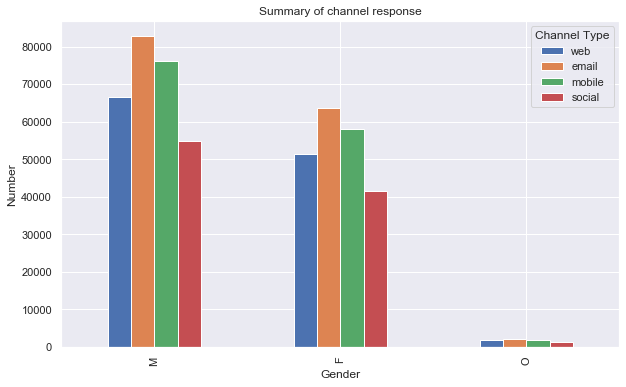

In [61]:
gender_offer = gender_sent.plot(kind='bar', 
                                title='Summary of channel response', 
                                figsize=(10, 6))
gender_offer.set_xlabel("Gender")
gender_offer.set_ylabel("Number")
plt.legend(title='Channel Type')
plt.show()

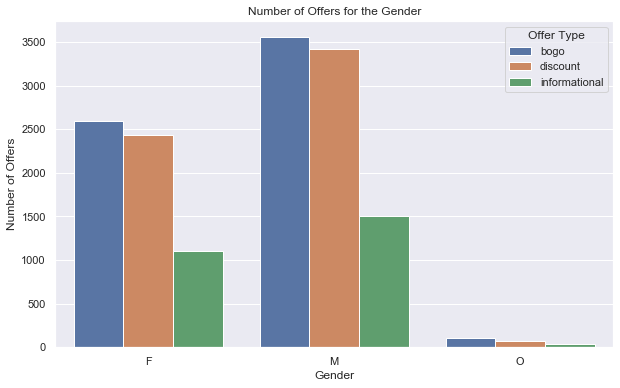

In [62]:
# Which type of promotions each gender likes
plt.figure(figsize=(10, 6))
sns.countplot(x=profile.gender, 
              hue = 'offer_type', data=df_offer)
plt.title('Number of Offers for the Gender')
plt.ylabel('Number of Offers')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.legend(title='Offer Type')
plt.savefig("./figure/number_of_offers_for_the_gender.jpg")
plt.show()

### Analyze Offer Statistics

These results suggest that distribution of offers in the simulated Starbucks mobile application data is approximately uniform. 



They also imply that the percentage of an offer's success ranges from ~ 6% to 75%, with the two least successful offers being informational.

!!!! tbd

In [63]:
# Calculate all offers 
count_successful = df_offer.groupby(['offer_id']).agg({'offer_id':'count'})

In [64]:
# show me the results
count_successful

,offer_id
offer_id,
0b1e1539f2cc45b7b9fa7c272da2e1d7,12247
2298d6c36e964ae4a3e7e9706d1fb8c2,17881
2906b810c7d4411798c6938adc9daaa5,13951
3f207df678b143eea3cee63160fa8bed,10144
4d5c57ea9a6940dd891ad53e9dbe8da0,16203
5a8bc65990b245e5a138643cd4eb9837,12516
9b98b8c7a33c4b65b9aebfe6a799e6d9,14325
ae264e3637204a6fb9bb56bc8210ddfd,16188
f19421c1d4aa40978ebb69ca19b0e20d,16960


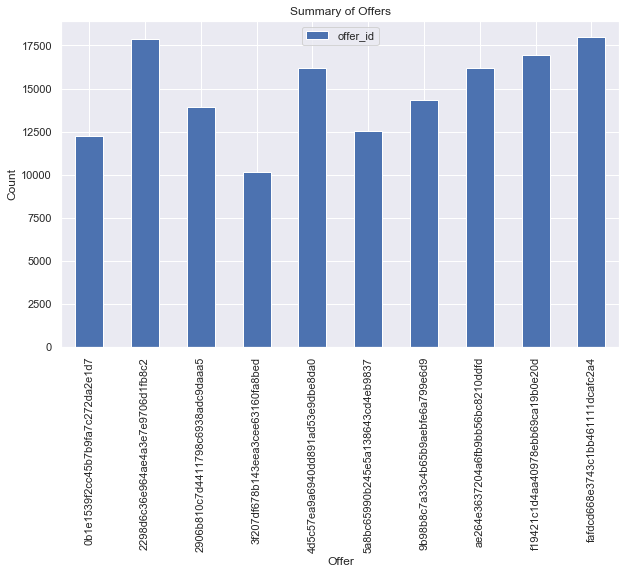

In [65]:
# plot the results of the offers
success_offer = count_successful.plot(kind='bar', 
                                      title='Summary of Offers',
                                      figsize=(10, 6))
success_offer.set_xlabel("Offer")
success_offer.set_ylabel("Count")
plt.show()

**Interims result**

It seems that there is an equal distribution of offers in the Starbucks app. BOGO and Discount are considered equally important for both women and men. In contrast, the informational offers are significantly lower.

A closer look at the offer channels, the email and mobile channels are more advantageous than those via the web or social networks.

With a deeper analysis of the possible offers, the following becomes clear when dividing up:

Discount with 62,095 offers is viewed the most frequently with 91% and the most successful with 63% completed answers.

The results of the BOGO are not bad either. Here the 63,676 data were after all a success rate of 65%.

The 22,660 information on the 4 offer channels, web, email, mobile and social networks are viewed with 70%.

<a id='Model'></a>
## 7 Modeling 
   

Setup the metric. In my case I want to use the 'Confusion Matrix'. A nice description I found here https://medium.com/thalus-ai/performance-metrics-for-classification-problems-in-machine-learning-part-i-b085d432082b.

To decide which model and thus the classification can, I need a method. I found this in the confusion matrix. With this the correctness and accuracy of a model can be determined. Now I have to define in advance what I mean by correctness and accuracy. The question helps me how many Starbucks customers use exactly one specific offer. This can be represented with this formula:


\begin{equation*}
Accuracy=\frac{True Positive + True Negative}{True Positive + False Positive + False Negative + True Negative}
\end{equation*}

\begin{equation*}
F1=2\times \frac{Precision\times Recall}{Precision+Recall}
\end{equation*}

\begin{equation*}
Precision=\frac{True Positive}{True Positive+False Positive}
\end{equation*}

\begin{equation*}
Recall=\frac{True Positive}{True Positive+False Negative}
\end{equation*}

<a id='LabelModel'></a>
### 7.1 Label for modeling 

For further analysis and modeling methods, evaluable numerical columns must be made from the   'category' data types. The information is temporarily stored for later use.

In [66]:
summary(df_offer)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148431 entries, 0 to 148430
Data columns (total 26 columns):
customer_id          148431 non-null object
offer_id             148431 non-null object
time                 148431 non-null float64
completed            148431 non-null uint8
received             148431 non-null uint8
viewed               148431 non-null uint8
reward               148431 non-null int64
difficulty           148431 non-null int64
duration             148431 non-null int64
offer_type           148431 non-null object
email                148431 non-null int64
mobile               148431 non-null int64
social               148431 non-null int64
web                  148431 non-null int64
bogo                 148431 non-null uint8
discount             148431 non-null uint8
informational        148431 non-null uint8
gender               148431 non-null object
age                  148431 non-null int64
income               148431 non-null float64
membership_start     

In [67]:
# Encode the labes and save this 
# data object customer_id
labels_customer_id = df_offer['customer_id'].astype('category').cat.categories.tolist()
map_tab_customer_id = {'customer_id' : {k: v for k,v in zip(labels_customer_id,list(range(1,len(labels_customer_id)+1)))}}
# data object offer_id
labels_offer_id = df_offer['offer_id'].astype('category').cat.categories.tolist()
map_tab_offer_id = {'offer_id' : {k: v for k,v in zip(labels_offer_id,list(range(1,len(labels_offer_id)+1)))}}
# data object offer_type
labels_offer_type = df_offer['offer_type'].astype('category').cat.categories.tolist()
map_tab_offer_type = {'offer_type' : {k: v for k,v in zip(labels_offer_type,list(range(1,len(labels_offer_type)+1)))}}
# data object genter
labels_gender = df_offer['gender'].astype('category').cat.categories.tolist()
map_tab_gender = {'gender' : {k: v for k,v in zip(labels_gender,list(range(1,len(labels_gender)+1)))}}
# print(replace_map_comp_gender)
# show me the mapping results
# print(map_tab_customer_id)
print(map_tab_offer_id)
print(map_tab_offer_type)
print(map_tab_gender)

{'offer_id': {'0b1e1539f2cc45b7b9fa7c272da2e1d7': 1, '2298d6c36e964ae4a3e7e9706d1fb8c2': 2, '2906b810c7d4411798c6938adc9daaa5': 3, '3f207df678b143eea3cee63160fa8bed': 4, '4d5c57ea9a6940dd891ad53e9dbe8da0': 5, '5a8bc65990b245e5a138643cd4eb9837': 6, '9b98b8c7a33c4b65b9aebfe6a799e6d9': 7, 'ae264e3637204a6fb9bb56bc8210ddfd': 8, 'f19421c1d4aa40978ebb69ca19b0e20d': 9, 'fafdcd668e3743c1bb461111dcafc2a4': 10}}
{'offer_type': {'bogo': 1, 'discount': 2, 'informational': 3}}
{'gender': {'F': 1, 'M': 2, 'O': 3}}


In [68]:
# now replace the categorical with numerical 
df_offer.replace(map_tab_customer_id, inplace=True)
df_offer.replace(map_tab_offer_id, inplace=True)
df_offer.replace(map_tab_offer_type, inplace=True)
df_offer.replace(map_tab_gender, inplace=True)

In [69]:
# show me the results in data frame after mapping
df_offer.sample(5)

,customer_id,offer_id,time,completed,received,viewed,reward,difficulty,duration,offer_type,...,informational,gender,age,income,membership_start,membership_period,member_year,member_month,member_day,member_date
105509,733,1,21.0,0,1,0,5,20,240,2,...,0,1,40,53000.0,2017-11-03,2017-11,2017,11,3,2017-11-03
142387,13390,8,25.5,0,0,1,10,10,168,1,...,0,1,67,34000.0,2015-07-27,2015-07,2015,7,27,2015-07-27
55517,2599,10,14.0,0,1,0,2,10,240,2,...,0,2,72,37000.0,2018-03-01,2018-03,2018,3,1,2018-03-01
106698,6922,9,21.0,0,1,0,5,5,120,1,...,0,1,60,43000.0,2018-06-11,2018-06,2018,6,11,2018-06-11
12377,3286,2,0.0,0,0,1,3,7,168,2,...,0,1,28,73000.0,2018-07-03,2018-07,2018,7,3,2018-07-03


<a id='NormModel'></a>
### 7. 2 Normalize for modeling 

I need the normalization of numerical values because I want to use them as features

In [70]:
# create features 
df_model = df_offer.copy()
scaler = MinMaxScaler()
to_normalize = ['time', 'age', 'income', 'member_year']
df_model[to_normalize] = scaler.fit_transform(df_model[to_normalize])

In [71]:
# at frist I split the data frame into target and features
X_features = df_model.drop(['offer_id',
                            'customer_id',
                            'time',
                            'completed', 
                            'received', 
                            'viewed',
                            'reward',
                            'email',
                            'mobile',
                            'social', 
                            'web',
                          'difficulty',
                          'duration',
                          'membership_start',
                          'membership_period',
                          'member_month',
                          'member_day',
                          'member_date',
                          'offer_type'], axis = 1)

In [72]:
X_features.sample(5)

,bogo,discount,informational,gender,age,income,member_year
22713,0,1,0,2,0.481928,0.566667,0.8
146510,0,1,0,2,0.012048,0.266667,0.4
32619,1,0,0,2,0.650602,0.455556,0.6
70086,1,0,0,2,0.554217,0.722222,0.6
140565,0,1,0,1,0.385542,0.511111,0.8


In [73]:
# create target
# Y_target = df_offer.offer_type
Y_target = df_offer['offer_type']

In [74]:
Y_target.sample(5)

23058     1
88074     3
136192    2
44924     2
101017    2
Name: offer_type, dtype: int64

In [75]:
# split the data in test and train
(X_train,
 X_test,
 y_train,
 y_test) = train_test_split(X_features, 
                            Y_target,
                            test_size=0.25,
                            random_state=42,
                           shuffle=True)
y_train = y_train.ravel()
y_test = y_test.ravel()

In [76]:
# Show me the results
print('Training Features: ', X_train.shape)
print('Training Labels: ', y_train.shape)
print('Testing Features: ', X_test.shape)
print('Testing Labels: ', y_test.shape)

Training Features:  (111323, 7)
Training Labels:  (111323,)
Testing Features:  (37108, 7)
Testing Labels:  (37108,)


In [77]:
X_train.sample(5)

,bogo,discount,informational,gender,age,income,member_year
79649,0,1,0,2,0.180723,0.166667,1.0
95685,0,1,0,2,0.554217,0.500000,0.4
1060,0,1,0,1,0.518072,0.500000,0.4
6764,1,0,0,2,0.530120,0.200000,0.8
60150,0,1,0,2,0.457831,0.044444,1.0


In [78]:
y_test

array([2, 2, 3, ..., 1, 2, 1], dtype=int64)

In [79]:
y_train

array([2, 2, 2, ..., 2, 2, 3], dtype=int64)

<a id='pipline'></a>
### 7.3 Make a Pipline to Find the Best Model

name SVC  acc2  100.0
name LogisticRegression  acc2  100.0
name DecisionTreeClassifier  acc2  100.0
name RandomForestClassifier  acc2  100.0
name GaussianNB  acc2  100.0
name AdaBoostClassifier  acc2  100.0


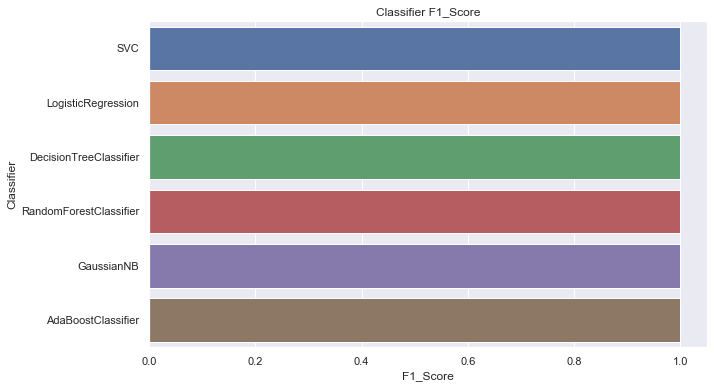

In [80]:
# Let's check out which classifier will work best in our case
# Instantiate the classifier pipline 
classifiers = [SVC(gamma='scale'),
               LogisticRegression(random_state=None, 
                                  multi_class='auto', 
                                  solver='lbfgs',
                                  max_iter=101), 
                DecisionTreeClassifier(),
                RandomForestClassifier(n_estimators=105),
                GaussianNB(),
                AdaBoostClassifier()]

perf_clf = pd.DataFrame(columns=["Classifier", "F1_Score"])

acc_dict = {}

nb_epoch=200
batch_size=10

for clf in classifiers:
    name = clf.__class__.__name__
    # Fit to the training data
    clf.fit(X_train, y_train)
    # Predict the labels of the test set
    y_pred = clf.predict(X_test)
    # y_pred = (y_pred > .5) * 1
    # calculate F1 Score with function f1_score
    acc = f1_score(y_pred, y_test, average='macro')
    ## calculate the absolute errors
    errors = abs(y_pred - y_test)
    ## calculate mean absolute percentage error
    mape = 100 * (errors / y_test)
    acc2 = 100 - np.mean(mape)
    print('name', name, ' acc2 ', acc2 )
    if name not in acc_dict:
        acc_dict[name] = acc
    else:
        acc_dict[name] += acc

for clf in acc_dict:
    perf_clf_row = pd.DataFrame([[clf, acc_dict[clf]]], columns=["Classifier", "F1_Score"])
    perf_clf = perf_clf.append(perf_clf_row)

plt.figure(figsize=(10, 6))
plt.xlabel('F1_Score')
plt.title('Classifier F1_Score')
plt.savefig("./figure/classifier_F1_score.jpg")
sns.barplot(x='F1_Score', y='Classifier', data=perf_clf);

In [82]:
perf_clf

,Classifier,F1_Score
0,SVC,1.0
0,LogisticRegression,1.0
0,DecisionTreeClassifier,1.0
0,RandomForestClassifier,1.0
0,GaussianNB,1.0
0,AdaBoostClassifier,1.0


#### Evaluating the model performance

In [83]:
# A naive predictor assumes that all customer offers were successful
# reference: https://www.ritchieng.com/machine-learning-evaluate-classification-model/
naive_predictor_accuracy = accuracy_score(y_train,np.ones(len(y_train)))
naive_predictor_f1score = f1_score(y_train, np.ones(len(y_train)), average='micro')

print("Naive predictor accuracy: %.3f" % (naive_predictor_accuracy))
print("Naive predictor f1-score: %.3f" % (naive_predictor_f1score))

Naive predictor accuracy: 0.429
Naive predictor f1-score: 0.429


<a id='improvements'></a>
### 7.4 Model Improvements

I have more than one best model. So is my decission for RandomForestClassifier as the best classifier. Therefore, we conduct GridSearch on it to find the best parameters:

In [84]:
# let see the training with random forest classifier  ... 
def fit_random_forest_classifier(features, target):
    #First let's create training and testing data
    X_train, X_test, Y_train, Y_test = train_test_split(features, 
                                                        target, 
                                                        test_size=0.33, 
                                                        random_state=42) 
    # I could grid search and tune, but let's just fit a simple model to see how it does
    # instantiate
    clf = RandomForestClassifier(n_estimators=1000, 
                                 n_jobs = 8, 
                                 max_features = 'auto', 
                                 bootstrap=False,
                                 max_depth=None)
    # get the full class name
    class_name = re.sub("[<>']", '', str(clf.__class__))
    class_name = class_name.split(' ')[1]
    class_name = class_name.split('.')[-1]
    # find best param
    param_grid = {
        'n_estimators': [200,500],
        'max_features': [.5,.7],
        'bootstrap': [False, True],
        'max_depth':[3,6]}
    scorer = make_scorer(fbeta_score,
                     beta=0.5, average='macro')
    # get the cross value score
    cv = ShuffleSplit()
    grid_obj = GridSearchCV(estimator=clf, 
                          param_grid=param_grid,
                          scoring = scorer,
                          n_jobs = 8,
                          verbose = 2)
    #fit
    grid_fit = grid_obj.fit(X_train, Y_train)
    # best classifier
    best_clf = grid_fit.best_estimator_
    #predict
    Y_pred = best_clf.predict(X_train)

    # Check the score
    clf_accuracy = accuracy_score(Y_train, Y_pred)
    clf_f1_score = f1_score(Y_train, Y_pred, average='micro')
    
    print("%s model accuracy: %.3f" % (class_name, clf_accuracy))
    print("%s model f1-score: %.3f" % (class_name, clf_f1_score))
    # crosstab = pd.crosstab(Y_test, Y_pred, rownames=['Actual Destrict'], colnames=['Predicted Destrict'])
    
    return best_clf, X_train, Y_pred

In [85]:
# Set timestamp
starttime = time.time()

In [86]:
best_clf, X_train, Y_preds = fit_random_forest_classifier(X_features, Y_target)

C:\Users\geral\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   25.9s
[Parallel(n_jobs=8)]: Done  48 out of  48 | elapsed:   47.5s finished


RandomForestClassifier model accuracy: 1.000
RandomForestClassifier model f1-score: 1.000


In [87]:
# show the runtime
runtime = time.time() - starttime    
print('Function completed in {:.0f}m {:.0f}s'.format(runtime // 60, runtime % 60))

Function completed in 0m 50s


In [88]:
# show best classifier
best_clf

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=3, max_features=0.5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=8,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

<a id='evaluation'></a>
## 8. Evaluation

<a id='features'></a>
### 8.1 Find the Best Features

In [89]:
# now I have a view to the importance features 
importances = best_clf.feature_importances_

In [90]:
std = np.std([best_clf.feature_importances_ for tree in best_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 0 (0.444123)
2. feature 1 (0.352814)
3. feature 2 (0.202954)
4. feature 5 (0.000074)
5. feature 6 (0.000021)
6. feature 4 (0.000013)
7. feature 3 (0.000000)


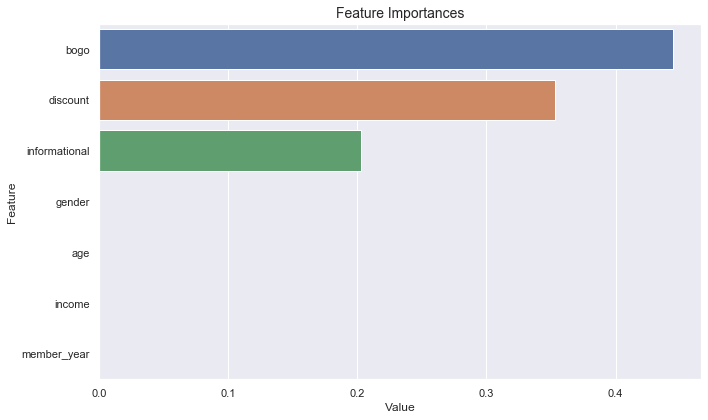

In [92]:
# Plot feature importance
feature_imp = pd.DataFrame(sorted(zip(importances[indices], X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Feature Importances', fontsize=14)
plt.tight_layout()
plt.savefig("./figure/importances_feature.jpg", bbox_inches='tight')
plt.show()

In [ ]:
<a id='PCA'></a>
### 8.2 PCA with the Offer Model 

The model RandomForestClassifier performs pretty well on the test set using the adjusted data. The most importance features in this case is the offer and behind this the time. Let's see how well a model works with PCA

In [93]:
# Transforms data using PCA to create n_components, and provides back the results of the
# transformation.
# n_components - int - the number of principal components to create
# data - the data you would like to transform

n_components = 5

scaler = StandardScaler().fit_transform(X_features)
# PCA model
offer_pca = PCA(n_components)
# PCA features
X_pca = offer_pca.fit_transform(scaler)

In [94]:
# Set timestamp
starttime = time.time()

In [95]:
clf_pca, X_train, Y_preds = fit_random_forest_classifier(X_pca, Y_target)

C:\Users\geral\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   53.0s
[Parallel(n_jobs=8)]: Done  48 out of  48 | elapsed:  1.5min finished


RandomForestClassifier model accuracy: 1.000
RandomForestClassifier model f1-score: 1.000


In [96]:
# show the runtime
runtime = time.time() - starttime    
print('Function completed in {:.0f}m {:.0f}s'.format(runtime // 60, runtime % 60))

Function completed in 1m 36s


In [97]:
clf_pca

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=3, max_features=0.5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=8,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [98]:
X_features.columns

Index(['bogo', 'discount', 'informational', 'gender', 'age', 'income',
       'member_year'],
      dtype='object')

In [99]:
offer_pca

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [102]:
# Set timestamp
starttime = time.time()

In [103]:
# Inverse encode data and give back a data frame
def pca_results(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

In [104]:
df_pca = pca_results(X_features, offer_pca)

In [105]:
# show the runtime
runtime = time.time() - starttime    
print('Function completed in {:.0f}m {:.0f}s'.format(runtime // 60, runtime % 60))

Function completed in 0m 2s


In [112]:
df_pca

,Explained Variance,bogo,discount,informational,gender,age,income,member_year
Dimension 1,0.2479,-0.7095,0.7045,0.0100,0.0087,0.0028,-0.0004,-0.0088
Dimension 2,0.2056,-0.0388,-0.0441,0.1138,0.4766,-0.5900,-0.6381,0.0355
Dimension 3,0.1804,-0.3136,-0.3273,0.8804,-0.0615,0.0920,0.0704,0.0477
Dimension 4,0.1432,-0.0090,-0.0240,0.0453,0.1582,0.0351,0.0412,-0.9845
Dimension 5,0.1252,0.0095,-0.0004,-0.0126,0.8350,0.4993,0.1679,0.1583


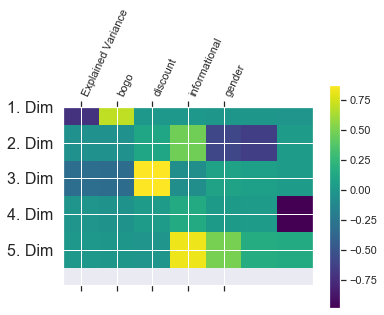

In [111]:
plt.matshow(offer_pca.components_,cmap='viridis')
# plt.figure(figsize=(10, 6))
plt.yticks([0,1,2,3,4,5],['1. Dim','2. Dim','3. Dim', '4. Dim', '5. Dim'],fontsize=16)
plt.colorbar()
plt.xticks(range(len(df_pca)),df_pca,rotation=65,ha='left')
plt.savefig("./figure/starbuck_PCA.jpg", bbox_inches='tight')
plt.show()

<a id='EvalConclusion'></a>
### 8.3 Conclusion 

Finally, I would like to reiterate my question. The questions about customers were processed according to income, gender and membership. The offers were shown exactly what it is. Here the 10 possible offers were divided into the offer types BOGO, discount and information. These are then divided according to their channels. With these results, the best possible version of the different models was made to infer the best offer.


<a id='Enhancement'></a>
### 8.4 Possible Enhancement in the Future

The offers made available do not include the product range. There are also no other general conditions, such as seasons. With the additional data, the various offers and customer behavior could then be used to offer further targeted offers via the app. In addition, the LSH - locality sensitive hashing would be a very good model to react to (see alsohttps://github.com/mattilyra/LSH/blob/master/examples/Introduction.ipynb)

<a id='Deploy'></a>
## 9 Deployment

Key findings from this analysis are used in a [blog post](https://medium.com/@geraldfranzkrieg/berlin-and-airbnb-a-deep-look-into-this-love-e0a70f3534ac?sk=ded53906389538ddcbd2a54f165deb34). 
This analysis can found [here](https://github.com/gerald-e/WADSBP_AirBnB)

In [ ]:
!jupyter nbconvert *.ipynb

In [ ]:
!pip freeze > requirements.txt